In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model

import os
import numpy as np
import pandas as pd
!pip install pickle5
import pickle5 as pickle
from scipy import ndimage
from skimage.transform import resize as sk_resize

In [11]:
# connect Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
# load data
path = '/content/drive/MyDrive/MIDS/w210'

with open(f'{path}/WM-clean.pkl', "rb") as fh:
    raw_data = pickle.load(fh)
    
print(f'Raw data shape: {raw_data.shape}')

Raw data shape: (172950, 11)


In [13]:
# add classification model labels
fail_types = raw_data.failureType.unique()
fail_dict = {fail_types[i]:i for i in range(len(fail_types))}
print(fail_dict)

raw_data['classify_labels'] = raw_data['failureType'].apply(lambda x: fail_dict[x])
raw_data.head()

{'none': 0, 'Loc': 1, 'Edge-Loc': 2, 'Center': 3, 'Edge-Ring': 4, 'Scratch': 5, 'Random': 6, 'Near-full': 7, 'Donut': 8}


,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,classify_labels
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0


In [14]:
# apply median filter
raw_data['filtered_map'] = raw_data.waferMap.apply(lambda x: ndimage.median_filter(x, size=3))

In [15]:
# resize images to 32x32
# normalize values to range of [0,1]
raw_data['resized_map'] = raw_data.waferMap.apply(lambda x: sk_resize(x/2, [32, 32], order=0, preserve_range=True, anti_aliasing=False))

In [16]:
# split data into train, dev, and test sets
train = raw_data[raw_data.dataset == 'train'].reset_index(drop=True)
dev = raw_data[raw_data.dataset == 'dev'].reset_index(drop=True)
test = raw_data[raw_data.dataset == 'test'].reset_index(drop=True)
print(f"Train: {len(train)}")
print(f"Dev: {len(dev)}")
print(f"Test: {len(test)}")

Train: 121065
Dev: 25942
Test: 25943


In [17]:
x_train = np.stack(train['resized_map'])
x_val = np.stack(dev['resized_map'])
x_test = np.stack(test['resized_map'])
x_train.shape

(121065, 32, 32)

In [18]:
# expand tensor and repeat 3 times
# images in greyscale, so no channel dimension
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_val = tf.expand_dims(x_val, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

x_train = tf.repeat(x_train, 3, axis=3)
x_val = tf.repeat(x_val, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)

x_train.shape

TensorShape([121065, 32, 32, 3])

In [19]:
y_train = np.asarray(train['classify_labels'])
y_val = np.asarray(dev['classify_labels'])
y_test = np.asarray(test['classify_labels'])

In [20]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)

  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)

  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)

  return tf.concat([path1, path2, path3, path4], axis=3)

In [21]:
inp = layers.Input(shape=(32, 32, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:])(inp)

x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)

x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=64,
              filters_3x3_reduce=96,
              filters_3x3=128,
              filters_5x5_reduce=16,
              filters_5x5=32,
              filters_pool=32)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=192,
              filters_5x5_reduce=32,
              filters_5x5=96,
              filters_pool=64)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=192,
              filters_3x3_reduce=96,
              filters_3x3=208,
              filters_5x5_reduce=16,
              filters_5x5=48,
              filters_pool=64)

aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)

x = inception(x,
              filters_1x1=160,
              filters_3x3_reduce=112,
              filters_3x3=224,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=256,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=112,
              filters_3x3_reduce=144,
              filters_3x3=288,
              filters_5x5_reduce=32,
              filters_5x5=64,
              filters_pool=64)

aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2)
aux2 = layers.Dense(10, activation='softmax')(aux2)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = inception(x,
              filters_1x1=384,
              filters_3x3_reduce=192,
              filters_3x3=384,
              filters_5x5_reduce=48,
              filters_5x5=128,
              filters_pool=128)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.4)(x)
out = layers.Dense(10, activation='softmax')(x)

In [22]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [23]:
model.compile(optimizer='adam', loss=[losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy], loss_weights=[1, 0.3, 0.3], metrics=['accuracy'])

In [24]:
history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), batch_size=64, epochs=10)

Epoch 1/10
1892/1892 [==============================] - 767s 396ms/step - loss: 0.7813 - dense_4_loss: 0.4856 - dense_1_loss: 0.4967 - dense_3_loss: 0.4888 - dense_4_accuracy: 0.8912 - dense_1_accuracy: 0.8889 - dense_3_accuracy: 0.8922 - val_loss: 0.7107 - val_dense_4_loss: 0.4579 - val_dense_1_loss: 0.4173 - val_dense_3_loss: 0.4254 - val_dense_4_accuracy: 0.9022 - val_dense_1_accuracy: 0.9052 - val_dense_3_accuracy: 0.9071
Epoch 2/10
1892/1892 [==============================] - 742s 392ms/step - loss: 0.6565 - dense_4_loss: 0.4145 - dense_1_loss: 0.4046 - dense_3_loss: 0.4020 - dense_4_accuracy: 0.9037 - dense_1_accuracy: 0.9100 - dense_3_accuracy: 0.9107 - val_loss: 0.6093 - val_dense_4_loss: 0.3859 - val_dense_1_loss: 0.3767 - val_dense_3_loss: 0.3683 - val_dense_4_accuracy: 0.9063 - val_dense_1_accuracy: 0.9146 - val_dense_3_accuracy: 0.9141
Epoch 3/10
1892/1892 [==============================] - 741s 391ms/step - loss: 0.6034 - dense_4_loss: 0.3781 - dense_1_loss: 0.3761 - dense

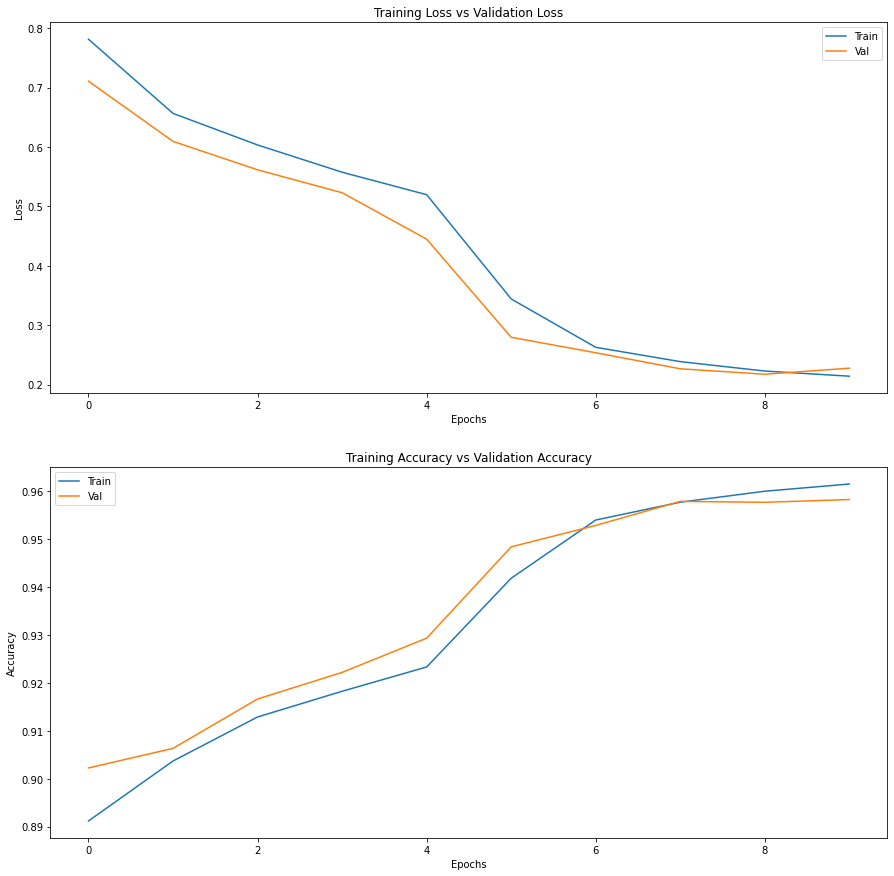

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['dense_4_accuracy'])
axs[1].plot(history.history['val_dense_4_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [26]:
model.evaluate(x_test, y_test)

811/811 [==============================] - 63s 74ms/step - loss: 0.2217 - dense_4_loss: 0.1394 - dense_1_loss: 0.1347 - dense_3_loss: 0.1395 - dense_4_accuracy: 0.9594 - dense_1_accuracy: 0.9606 - dense_3_accuracy: 0.9593


[0.22166571021080017,
 0.1393798440694809,
 0.13474109768867493,
 0.13954545557498932,
 0.9594110250473022,
 0.9606444835662842,
 0.9593338966369629]